# Models fit to text data and Neural Networks 

### Fiona Fang

## Part 1: Build a classification model using text data



### 1. Import the text data

In [1]:
# Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow.keras as keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load data
X = pd.read_csv('/Users/jiaying/Desktop/GR5073_ML/HW4_data/X_train.csv')
X.head(5)


,headline
0,MyBook Disk Drive Handles Lots of Easy Backups
1,CIT Posts Eighth Loss in a Row
2,"Candy Carson Singing The ""National Anthem"" Is ..."
3,Why You Need To Stop What You're Doing And Dat...
4,27 Times Adele Proved She's Actually The Reale...


In [4]:
y = pd.read_csv('/Users/jiaying/Desktop/GR5073_ML/HW4_data/y_train.csv')
y.head(5)


,label
0,not clickbait
1,not clickbait
2,clickbait
3,clickbait
4,clickbait


In [5]:
# Replace "not clickbait" with 0 and "clickbait" with 1
y['label'] = y['label'].replace({'not clickbait': 0, 'clickbait': 1})
y.head(5)


,label
0,0
1,0
2,1
3,1
4,1


### 2. Vectorize the clickbait headline column into an X matrix. Run logistic regression at least three times and select a single best model.

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(19983, 1) (4996, 1) (19983, 1) (4996, 1)


In [7]:
X_train = X_train['headline'].astype(str)
X_test = X_test['headline'].astype(str)
y_train = y_train['label'].astype(str)
y_test = y_test['label'].astype(str)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19983,) (4996,) (19983,) (4996,)


#### Tokenization approach 1: Use **CountVectorizer**


In [64]:
# Narrow bag of words to words in at least 5 documents
# Limit vocabulary to meaningful words by deleting Stop-words
vectorizer_word = CountVectorizer(min_df=5, stop_words="english").fit(X_train)
X_train_vectorized_word = vectorizer_word.transform(X_train)
X_test_vectorized_word = vectorizer_word.transform(X_test)

print("X_train_vectorized_word:\n{}".format(repr(X_train_vectorized_word)))


X_train_vectorized_word:
<19983x4479 sparse matrix of type '<class 'numpy.int64'>'
	with 95711 stored elements in Compressed Sparse Row format>


In [65]:
feature_names = vectorizer_word.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 210 to 230:\n{}".format(feature_names[210:230]))
print("Every 200th feature:\n{}".format(feature_names[::200]))

Number of features: 4479
First 20 features:
['000' '00s' '08' '09' '10' '100' '11' '12' '13' '14' '140' '15' '16' '17'
 '18' '19' '1989' '20' '200' '2000s']
Features 210 to 230:
['airbus' 'aircraft' 'airline' 'airliner' 'airlines' 'airplane' 'airport'
 'airstrikes' 'airways' 'al' 'alabama' 'aladdin' 'alan' 'alarm' 'alaska'
 'album' 'albums' 'alcoholic' 'alert' 'alex']
Every 200th feature:
['000' 'agree' 'awarded' 'breaking' 'chief' 'country' 'dictionary' 'end'
 'financial' 'greater' 'houses' 'jump' 'literature' 'minds' 'officials'
 'player' 'railway' 'rival' 'shared' 'starting' 'teens' 'tyra' 'wins']


In [66]:
print("X data shape: ", X_train_vectorized_word.shape, X_test_vectorized_word.shape)
print("Y data shape: ", y_train.shape, y_test.shape)

X data shape:  (19983, 4479) (4996, 4479)
Y data shape:  (19983,) (4996,)


In [67]:
# Use GridSearchCV to tune the parameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_vectorized_word, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.95
Best parameters:  {'C': 1}


In [68]:
# Use cross-validation to evaluate the results
model1 = LogisticRegression(C=1) # With best parameters

scores = cross_val_score(model1, X_train_vectorized_word, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
print("Test score: {:.2f}".format(grid.score(X_test_vectorized_word, y_test)))

Mean cross-validation accuracy: 0.95
Test score: 0.94


In [69]:
#  Use a robust metric for classification
model1 = LogisticRegression(C=1)
model1.fit(X_train_vectorized_word, y_train)

y_pred = model1.predict(X_test_vectorized_word)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      2610
           1       0.95      0.93      0.94      2386

    accuracy                           0.94      4996
   macro avg       0.94      0.94      0.94      4996
weighted avg       0.94      0.94      0.94      4996



In [70]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")



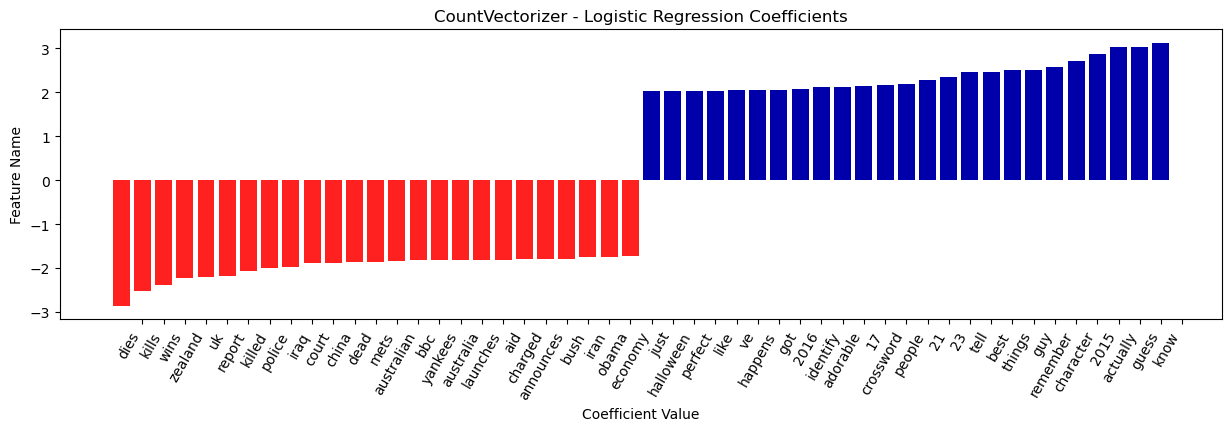

In [71]:
# Visualize coefficients
coefs = model1.fit(X_train_vectorized_word,y_train).coef_
feature_names = vectorizer_word.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=25)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('CountVectorizer - Logistic Regression Coefficients')
plt.show()

#### Tokenization approach 2: N-gram Tokenization


In [72]:
# N-gram Tokenization
ngram_vectorizer = CountVectorizer(ngram_range=(1,2), stop_words="english").fit(X_train)
X_train_ngram = ngram_vectorizer.transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

print("X_train_ngram:\n{}".format(repr(X_train_ngram)))


X_train_ngram:
<19983x97760 sparse matrix of type '<class 'numpy.int64'>'
	with 216073 stored elements in Compressed Sparse Row format>


In [73]:
feature_names = ngram_vectorizer.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 210 to 230:\n{}".format(feature_names[210:230]))
print("Every 200th feature:\n{}".format(feature_names[::200]))

Number of features: 97760
First 20 features:
['00' '00 disney' '000' '000 000' '000 american' '000 animals'
 '000 backup' '000 birds' '000 bodies' '000 carnations' '000 children'
 '000 civilians' '000 class' '000 commercial' '000 copy' '000 dangerous'
 '000 deaths' '000 doctor' '000 ducklings' '000 euros']
Features 210 to 230:
['100 important' '100 killed' '100 love' '100 madoff' '100 mortgages'
 '100 need' '100 night' '100 participate' '100 people' '100 point'
 '100 political' '100 right' '100 season' '100 shiite' '100 strike'
 '100 sure' '100 thousand' '100 times' '100 tv' '100 year']
Every 200th feature:
['00' '100 baghdad' '12 celebrity' '13 simple' '15 honest' '16 situations'
 '17 street' '19 actually' '1989' '2007 says' '2015 neil' '21 secrets'
 '23 people' '25 insanely' '27 small' '300 darfur' '36 absolute' '46 best'
 '64 sophomore' '90s food' 'abortion liberalisation' 'accident india'
 'acne' 'actresses obviously' 'actually vacation'
 'administration endorsed' 'advance final' '

In [74]:
print("X data shape: ", X_train_ngram.shape, X_test_ngram.shape)
print("Y data shape: ", y_train.shape, y_test.shape)

X data shape:  (19983, 97760) (4996, 97760)
Y data shape:  (19983,) (4996,)


In [75]:
# Use GridSearchCV to tune the parameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_ngram, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.95
Best parameters:  {'C': 10}


In [76]:
# Use cross-validation to evaluate the results
model2 = LogisticRegression(C=10) # With best parameters

scores = cross_val_score(model2, X_train_ngram, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
print("Test score: {:.2f}".format(grid.score(X_test_ngram, y_test)))

Mean cross-validation accuracy: 0.95
Test score: 0.95


In [77]:
#  Use a robust metric for classification
model2 = LogisticRegression(C=10)
model2.fit(X_train_ngram, y_train)

y_pred_ngram = model2.predict(X_test_ngram)

accuracy = accuracy_score(y_test, y_pred_ngram)
classification_rep = classification_report(y_test, y_pred_ngram)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      2610
           1       0.95      0.95      0.95      2386

    accuracy                           0.95      4996
   macro avg       0.95      0.95      0.95      4996
weighted avg       0.95      0.95      0.95      4996



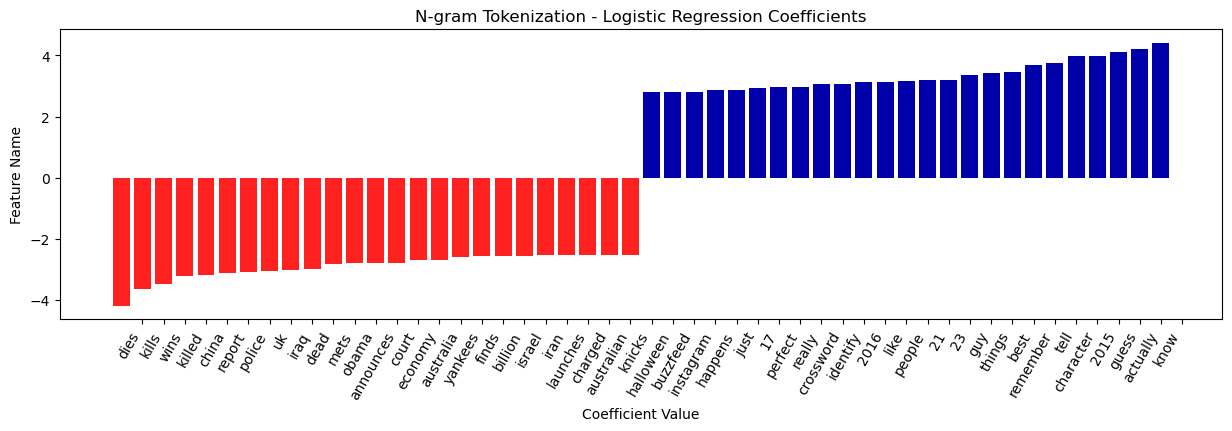

In [78]:
# Visualize coefficients
coefs = model2.fit(X_train_ngram,y_train).coef_
feature_names = ngram_vectorizer.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=25)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('N-gram Tokenization - Logistic Regression Coefficients')
plt.show()

#### Tokenization approach 3: TF-IDF Tokenizer


In [80]:
# TF-IDF Tokenization
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,3) , min_df=5, norm=None).fit(X_train)
X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print("X_train_tfidf:\n{}".format(repr(X_train_tfidf)))


X_train_tfidf:
<19983x9238 sparse matrix of type '<class 'numpy.float64'>'
	with 214514 stored elements in Compressed Sparse Row format>


In [81]:
feature_names = vectorizer_tfidf.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 210 to 230:\n{}".format(feature_names[210:230]))
print("Every 200th feature:\n{}".format(feature_names[::200]))

Number of features: 9238
First 20 features:
['000' '000 jobs' '000 people' '00s' '08' '09' '10' '10 000' '10 things'
 '10 things hate' '10 years' '100' '100 000' '100 years' '100 years of'
 '11' '11 charts' '11 charts that' '11 things' '11 times']
Features 210 to 230:
['27 things' '27 times' '27 tweets' '28' '29' '29 of' '29 of the'
 '29 things' '29 times' '2nd' '30' '30 rock' '300' '300 000' '31'
 '31 tweets' '32' '33' '34' '35']
Every 200th feature:
['000' '25 things' 'adorable' 'and people are' 'ask' 'be your valentine'
 'border' 'candidates' 'cia' 'cook' 'death toll' 'diversity' 'embassies'
 'fall' 'foot' 'gave' 'guilty in' 'here the' 'identify' 'in this'
 'isolated' 'kills seven' 'libya' 'made in' 'mid' 'national' 'of an'
 'once upon time' 'penguins' 'poll' 'qantas' 'related' 'ruby' 'sent'
 'slay' 'steel' 'taliban' 'the buzzfeed' 'they are' 'to be in' 'tornadoes'
 'unit' 'walking dead' 'what would you' 'with' 'you have in' 'your sign']


In [82]:
print("X data shape: ", X_train_tfidf.shape, X_test_tfidf.shape)
print("Y data shape: ", y_train.shape, y_test.shape)

X data shape:  (19983, 9238) (4996, 9238)
Y data shape:  (19983,) (4996,)


In [83]:
# Use GridSearchCV to tune the parameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.97
Best parameters:  {'C': 0.1}


In [84]:
# Use cross-validation to evaluate the results
model3 = LogisticRegression(C=0.1) # With best parameters

scores = cross_val_score(model3, X_train_tfidf, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
print("Test score: {:.2f}".format(grid.score(X_test_tfidf, y_test)))


Mean cross-validation accuracy: 0.97
Test score: 0.97


In [86]:
#  Use a robust metric for classification
model3 = LogisticRegression(C=1)
model3.fit(X_train_tfidf, y_train)

y_pred = model3.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2610
           1       0.97      0.96      0.97      2386

    accuracy                           0.97      4996
   macro avg       0.97      0.97      0.97      4996
weighted avg       0.97      0.97      0.97      4996



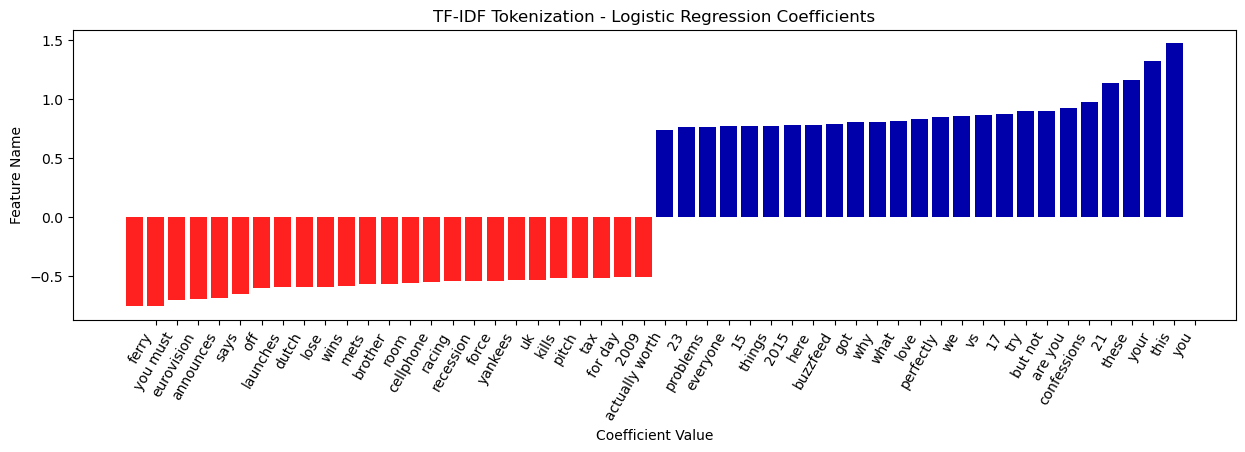

In [87]:
# Visualize coefficients
coefs = model3.fit(X_train_tfidf,y_train).coef_
feature_names = vectorizer_tfidf.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=25)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('TF-IDF Tokenization - Logistic Regression Coefficients')
plt.show()


Model 1:
- Cross validation score: 0.95
- Test score: 0.94
- Accuracy: 0.94
- F1 score: 0.95, 0.94

Model 2:
- Cross validation score: 0.95 
- Test score: 0.95
- Accuracy: 0.95
- F1 score: 0.95

Model 3:
- Cross validation score: 0.97
- Test score: 0.97
- Accuracy: 0.97
- F1 score: 0.97


By comparing these result, we can see that the model 3 is the best model because it has the highest score of cv score, test set score, accuracy and f1 score among all 3 models. Thus, the model 3 is the best model.  

## Part 2: Build a predictive neural network using Keras

In [88]:
# Read csv file
df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv")
df.head()

,rownames,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [89]:
# Encode the target variable
le = LabelEncoder()
df['Species'] = le.fit_transform(df['Species'])

# Split the data into features (X) and target variable (y)
X = df.drop('Species', axis=1)
y = df['Species']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Species, dtype: int64

In [90]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head(5)


,rownames,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
22,23,4.6,3.6,1.0,0.2
15,16,5.7,4.4,1.5,0.4
65,66,6.7,3.1,4.4,1.4
11,12,4.8,3.4,1.6,0.2
42,43,4.4,3.2,1.3,0.2


In [91]:
y_train.head(5)

22    0
15    0
65    1
11    0
42    0
Name: Species, dtype: int64

In [92]:
#scale my X data
sc = StandardScaler()
sc.fit(X_train)
X_test_scaled = sc.transform(X_test)
X_train_scaled = sc.transform(X_train)

print("X train shape: ", X_train_scaled.shape)

X train shape:  (120, 5)


### Model 1: 

In [ ]:
# Model 1: a single-input model with 2 classes (binary classification):
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=5))
model.add(Dense(1, activation='softmax', input_dim=5))
optimizer = SGD(learning_rate = 0.1)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics='AUC')

model.fit(X_train_scaled, y_train, epochs=10, batch_size=128, validation_split=.2)

2023-12-05 14:37:44.155509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-05 14:37:44.155545: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 14:37:44.155557: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 14:37:44.155839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 14:37:44.156277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


In [17]:
score = model.evaluate(X_test_scaled, y_test, batch_size=128) # extract loss and accuracy from test data evaluation
print(score)


1/1 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - auc: 0.5000
[0.0, 0.5]


In [18]:
#just so I know what my first model looks like
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                192       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model 2: MLP with 3 hidden layers and 20 neurons each
model2 = Sequential()
model2.add(Dense(20, input_dim=5, activation='relu')) 
model2.add(Dense(20, activation='relu'))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(3, activation='softmax'))
sgd = SGD(lr=0.0001)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model, iterating on the data in batches of 128 samples
model2.fit(X_train_scaled, y_train, epochs=20, batch_size=128)


In [ ]:
# Evaluate models on the test set
y_prob1 = model1.predict(X_test)
y_prob2 = model2.predict(X_test)

# Convert probabilities to class labels
y_pred1 = np.argmax(y_prob1, axis=1)
y_pred2 = np.argmax(y_prob2, axis=1)

accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)

print("Model 1 Accuracy: {:.2f}".format(accuracy1))
print("Model 2 Accuracy: {:.2f}".format(accuracy2))


In [ ]:
score = model1.evaluate(X_test, y_test, batch_size=32) # extract loss and accuracy from test data evaluation
print(score)


In [ ]:
score = model2.evaluate(X_test, y_test, batch_size=128) # extract loss and accuracy from test data evaluation
print(score)